In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

HARDWARES = ["A100", "RTX"]
P         = np.arange(2, 10)
CG_FOLDER = "../experiments/cg_2D"
PERFORMANCE_FOLDER = "../experiments/mat_free_"
SCALAR_TYPES = ["float32", "float64"]


In [3]:
def parse_cg_file(filename):
    pcg = np.nan; cg = np.nan
    with open(filename, 'r') as f:
        for line in f:
            m = re.search(r'Number of GPU PCG iterations\s*([0-9.]+)', line)
            if m: pcg = float(m.group(1))
            m = re.search(r'Number of GPU CG iterations\s*([0-9.]+)', line)
            if m: cg  = float(m.group(1))
    return pcg, cg

def parse_gdofs_file(filename):
    sf_otf = np.nan
    sf = np.nan
    baseline = np.nan
    with open(filename, 'r') as f:
        for line in f:
            m1 = re.search(r'SF OTF Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m1:
                sf_otf = float(m1.group(1))
            m2 = re.search(r'Baseline Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m2:
                baseline = float(m2.group(1))
            m3 = re.search(r'SF Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m3:
                sf = float(m3.group(1))
    return sf, sf_otf, baseline

In [4]:
# Load CG data
b_pcg, b_cg = zip(*(parse_cg_file(f'{CG_FOLDER}/log_bernstein_{i}.txt') for i in P))
g_pcg, g_cg = zip(*(parse_cg_file(f'{CG_FOLDER}/log_gll_{i}.txt')       for i in P))

# Create CG DataFrame
cg_df = pd.DataFrame({
    'P': list(P),
    'Bernstein_PCG': b_pcg,
    'Bernstein_CG': b_cg,
    'GLL_PCG': g_pcg,
    'GLL_CG': g_cg
})

# Get hardware data
performance_data = []

for scalar_type in SCALAR_TYPES:
    for hardware in HARDWARES:
        try:
            sf_vals, sf_otf_vals, base_vals = zip(*(parse_gdofs_file(f'{PERFORMANCE_FOLDER}{hardware}/log_{scalar_type}_{i}.txt') for i in P))
            
            # Add to performance data list
            for i, p_val in enumerate(P):
                performance_data.append({
                    'P': p_val,
                    'Hardware': hardware,
                    'ScalarType': scalar_type,
                    'SF': sf_vals[i],
                    'SF_OTF': sf_otf_vals[i],
                    'Baseline': base_vals[i]
                })
        except FileNotFoundError:
            print(f"File not found for {hardware} with scalar type {scalar_type}. Skipping...")

# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)

In [5]:
# Display the CG DataFrame
print("CG Data:")
display(cg_df)

# Display the Performance DataFrame
print("\nPerformance Data:")
display(perf_df)

CG Data:


,P,Bernstein_PCG,Bernstein_CG,GLL_PCG,GLL_CG
0,2,16.0,43.0,9.0,26.0
1,3,22.0,81.0,9.0,31.0
2,4,35.0,118.0,9.0,36.0
3,5,55.0,202.0,11.0,41.0
4,6,93.0,298.0,12.0,52.0
5,7,108.0,369.0,15.0,60.0
6,8,168.0,440.0,18.0,74.0
7,9,165.0,380.0,22.0,91.0



Performance Data:


,P,Hardware,ScalarType,SF,SF_OTF,Baseline
0,2,A100,float32,1.98692,0.683357,1.98136
1,3,A100,float32,4.33443,0.999923,4.42643
2,4,A100,float32,6.36261,0.647735,7.80978
3,5,A100,float32,7.21758,0.671735,6.71283
4,6,A100,float32,9.58651,0.969074,5.79522
5,7,A100,float32,7.52814,0.894474,4.02623
6,8,A100,float32,8.84483,0.547783,3.49249
7,9,A100,float32,8.69997,0.544063,2.96105
8,2,RTX,float32,3.49720,0.358922,3.53094
9,3,RTX,float32,7.77208,0.443892,7.90300


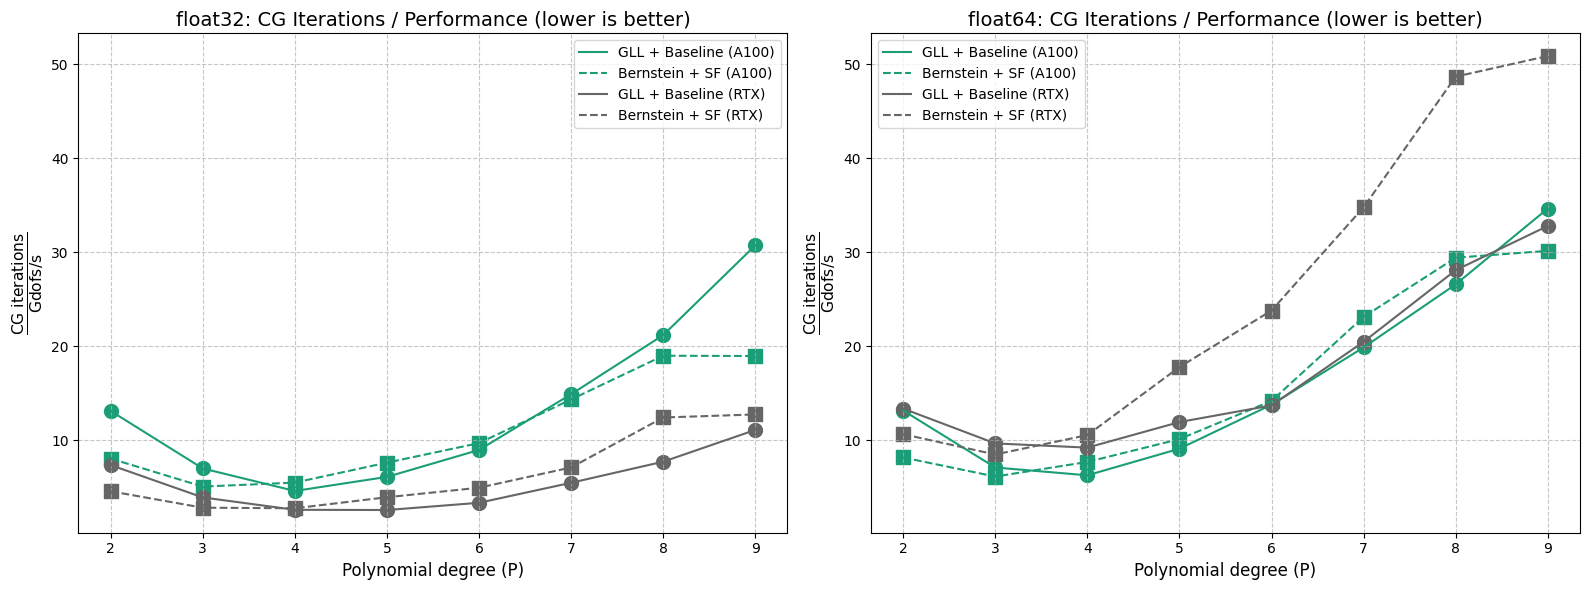

In [6]:
# Plot: CG iterations / gdofs/s = [CGdofs * s]
# For baseline algorithm, GLL and Bernstein are available. The best is always GLL.
# For SF, SF_OTF, only Bernstein is available

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
markers = ['o', 's', '^', 'D', 'x']
# Use a different colormap with more distinct colors for hardware types
colors = plt.cm.Dark2(np.linspace(0, 1, len(HARDWARES)))

# Collect all y values to determine common y limits
all_y_values = []

# Plot for float32
ax = axes[0]
float32_df = perf_df[perf_df['ScalarType'] == 'float32']

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    hw_df = float32_df[float32_df['Hardware'] == hardware]
    
    # For GLL with baseline (best baseline scenario)
    gll_baseline_vals = []
    for p_val in P:
        gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
        hw_p_df = hw_df[hw_df['P'] == p_val]
        if len(hw_p_df) > 0 and not np.isnan(gll_cg):
            baseline = hw_p_df['Baseline'].values[0]
            if not (np.isnan(gll_cg) or np.isnan(baseline)):
                y_val = gll_cg / baseline
                all_y_values.append(y_val)
                gll_baseline_vals.append((p_val, y_val))
    
    # Plot points and line if we have data
    if gll_baseline_vals:
        p_vals, y_vals = zip(*gll_baseline_vals)
        ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=100)
        ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                label=f'GLL + Baseline ({hardware})', linestyle='-')
    
    # For Bernstein with different approaches
    methods = [
        # ('Bernstein_CG', 'Baseline', 'Bernstein + Baseline'),
        ('Bernstein_PCG', 'SF', 'Bernstein + SF'),
        # ('Bernstein_PCG', 'SF_OTF', 'Bernstein + SF_OTF')
    ]
    
    for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
        method_vals = []
        for p_val in P:
            cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
            hw_p_df = hw_df[hw_df['P'] == p_val]
            if len(hw_p_df) > 0 and not np.isnan(cg_val):
                perf_val = hw_p_df[perf_col].values[0]
                if not (np.isnan(cg_val) or np.isnan(perf_val)):
                    y_val = cg_val / perf_val
                    all_y_values.append(y_val)
                    method_vals.append((p_val, y_val))
        
        # Plot points and line if we have data
        if method_vals:
            p_vals, y_vals = zip(*method_vals)
            marker_style = markers[method_idx]
            ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=100)
            ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                    label=f'{method_label} ({hardware})', linestyle='--')

ax.set_title('float32: CG Iterations / Performance (lower is better)', fontsize=14)
ax.set_xlabel('Polynomial degree (P)', fontsize=12)
ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)

# Plot for float64
ax = axes[1]
float64_df = perf_df[perf_df['ScalarType'] == 'float64']

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    hw_df = float64_df[float64_df['Hardware'] == hardware]
    
    # For GLL with baseline (best baseline scenario)
    gll_baseline_vals = []
    for p_val in P:
        gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
        hw_p_df = hw_df[hw_df['P'] == p_val]
        if len(hw_p_df) > 0 and not np.isnan(gll_cg):
            baseline = hw_p_df['Baseline'].values[0]
            if not (np.isnan(gll_cg) or np.isnan(baseline)):
                y_val = gll_cg  / baseline
                all_y_values.append(y_val)
                gll_baseline_vals.append((p_val, y_val))
    
    # Plot points and line if we have data
    if gll_baseline_vals:
        p_vals, y_vals = zip(*gll_baseline_vals)
        ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=100)
        ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                label=f'GLL + Baseline ({hardware})', linestyle='-')
    
    # For Bernstein with different approaches
    for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
        method_vals = []
        for p_val in P:
            cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
            hw_p_df = hw_df[hw_df['P'] == p_val]
            if len(hw_p_df) > 0 and not np.isnan(cg_val):
                perf_val = hw_p_df[perf_col].values[0]
                if not (np.isnan(cg_val) or np.isnan(perf_val)):
                    y_val = cg_val / perf_val
                    all_y_values.append(y_val)
                    method_vals.append((p_val, y_val))
        
        # Plot points and line if we have data
        if method_vals:
            p_vals, y_vals = zip(*method_vals)
            marker_style = markers[method_idx]
            ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=100)
            ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                    label=f'{method_label} ({hardware})', linestyle='--')

ax.set_title('float64: CG Iterations / Performance (lower is better)', fontsize=14)
ax.set_xlabel('Polynomial degree (P)', fontsize=12)
ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)

# Set the same y-limits for both plots
all_y_values = [y for y in all_y_values if not np.isnan(y)]
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min = max(0, y_min - 0.05 * y_range)  # Ensure we don't go below zero
    y_max = y_max + 0.05 * y_range
    
    for ax in axes:
        ax.set_ylim(y_min, y_max)
        # pass

plt.tight_layout()
plt.show()